#Disaster Detection via Twitter

**Final project for General Assembly Data Science course in Austin TX**

Ryan B. Jadrich

LinkedIn: [https://www.linkedin.com/in/ryan-jadrich-71190b5b](https://www.linkedin.com/in/ryan-jadrich-71190b5b)

Email: rjadrich@gmail.com

###1. Project summary
---
**Goal:** Create a predictive model to classify a tweet as pertaining to a disaster event or not, *solely* based on the tweet text.

**Data:** 10,876 classified tweet entries in the "Disasters on Social Media" data set from CrowdFlower at http://www.crowdflower.com/data-for-everyone. Some examples of disasters include structural collapses, wildfires and terrorist attacks. However, this dataset also encompasses more "minor" events such as car accidents, etc. These were compiled by searching for tweets with disaster related keywords (i.e., hijacking, hurricane, and explosion) and then they were classified as "Relevant", "Not Relevant" or "Can't Decide" with "Relevant" indicating a disaster.

**Auxiliary data:** Pretrained "Google News" dataset for word2vec at https://code.google.com/archive/p/word2vec/. This will be used to artificially boost the vocabulary of the model which is somewhat limited due to the smaller size of the tweet data set.

**Machine learning tools** 

1. **Natural Language Toolkit (NLTK)** - For initial preprocessing and tokenization of tweets using the nltk.tokenize package.

2. **GENSIM** - For seamless transformation from a high dimensional "bag of words" (BOW) feature space to a lower dimensional "topic" space (each topic expresses discovered relations amongst the words in the Tweet data set using Latent Semantic Indexing or LSI).

3. **Scikit-Learn** - For trivial implementation the final Logistic Regression model which predicts "disaster" or "not disaster" based on each Tweets "topic" representation.

**Using the model**: Clone the entire Git repository to your local machine and install any packages not already installed (likely NLTK and GENSIM). All data used by the notebook is included in the repository so, in principle, the notebook should be ready to deploy and improve upon. Please let me know of any major improvements!   :) 

**All of the required imports**

In [2]:
import numpy as np
import pandas as pd
import string
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from scipy import interp
import matplotlib.pyplot as plt
import HTMLParser
import sys
import json
import tokensplicer
from nltk.corpus import brown
import re
from copy import deepcopy
%matplotlib inline 

###2. Check out the data
---

In [2]:
df = pd.read_csv("data/tweets/disaster-tweets.csv")
print df.columns

Index([u'_unit_id', u'_golden', u'_unit_state', u'_trusted_judgments',
       u'_last_judgment_at', u'choose_one', u'choose_one:confidence',
       u'choose_one_gold', u'keyword', u'location', u'text', u'tweetid',
       u'userid'],
      dtype='object')


**What is relevant?**

1. **_choose_one** - classification ("Relevant", "Not Relevant", or "Can't Decide")

2. **_choose_one_confidence** - the certainty of the final classification

3. **_text** - this is the actual tweet text

**Other, somewhat, relevant details**

1. **_golden** - "TRUE" or "FALSE" to indicate if the assigned classification is at the "golden" level, meaning hundreds of people voted on the classification. If not, five to six people voted on the classification. This is really supposed to be used as a final test set, but I don't do this.

2. **_unit_state** - indicates if the judgement on classifying the tweets is "finalized", "golden" (this is like super finalized) or "not finalized". All tweets are either "finalized" or "golden".

3. **keyword** - while not studied here, understanding what keywords are faithful indicators of disaster could be useful and improve model performance.

There are 10,876 total tweets with a fairly even representation of both "Relevant" and "Not Relevant" classes. Very few are labeled as "Can't Decide" and they will not be relevant to the binary model developed (discussed below).

**Only keep the columns relevant to this work**

In [3]:
df = df[["choose_one", "text", "choose_one:confidence"]]

**Check for any duplicate tweets and keep only one of the instances**

In [4]:
print "Total tweets: %d" % len(df)
df = df.drop_duplicates(cols = ["text"]).reset_index() #this also resets the index otherwise the numbers will have gaps
print "Total unique tweets: %d" % len(df)

Total tweets: 10876
Total unique tweets: 10678


C:\Users\rbj428\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\util\decorators.py:81: FutureWarning: the 'cols' keyword is deprecated, use 'subset' instead
  warnings.warn(msg, FutureWarning)


Indeed, there were a bunch of duplicates! This may be due to re-tweeting CrowdFlower not carefully checking for identical text.

###3. Clean and tokenize all the tweets
---
1. Convert hyphens and apostrophes from utf8 to ascii
2. Remove all remaining utf8 characters
3. Clean any HTML tags using HTMLParser module
4. Break on hyphens
5. Employ NLTK for initial tweet tokenization
  * Keep handles (no username) and hashtags (with text) and reduce length (e.g., looooooovvvvveeee to looovvveee)
6. Split up hastag text using **new** token splitter functionality
7. Replace the top 90% (http://www.datagenetics.com/blog/october52012/index.html) of emoticons with **|-happy-|**, **|-sad-|** or **|-inert-|** tokens
7. Introduce special tokens
  * **|-num-|** for numbers (detect comma separation as in 1,000,000)
  * **|-num_alpha-|** for mixed numerical and alphabetical (maybe useful for interstates, planes, trains, ...) 
    * Make sure not to convert handles! These are typically mixed numeric and alphabetic
  * **|-num_units-|** for zero, one, ..., ten
  * **|-num_tens-|** for ten, twenty, ..., ninety
  * **|-num_scales-|** for hundred, thousand, ..., billion
  * **|-website-|** for any hyperlinks
9. Stem words using NLTK Porter stemmer (e.g., fires becomes fire)

**NOTE:** stop words (i.e., high frequency words like "and") are not removed as is commonly done in natural language processing tasks. Interestingly, keeping them helps improve the final model performance--perhaps by allowing for better word-word relations to be encoded in the discovered "topics".

**Assortment of function definitions for cleaning and tokenizing**

In [5]:
#initialize splitter
split = tokensplicer.Token_Splicer()

#make a modified brown corpus and train the model
modified_brown = [word.lower() for word in brown.words() 
                  if (len(word) > 2 or word.lower() 
                      in ("a i an as at be bi by do he hi if in is it " +
                      "me my no of or on so to up us we").split(" "))]

#initialize the splitter
split.make_freq(modified_brown)


#go through and find all utf8 hyphens and apostrophes and convert to ascii
def utf8_to_ascii(tweet):
    utf8_hyphens = "\xe2\x80\x90 \xe2\x80\x91 \xe2\x80\x92 \xe2\x80\x93 \xe2\x80\x94".split()
    utf8_aposts = "\xe2\x80\x98 \xe2\x80\x99 \xe2\x80\x9b \xe2\x80\xb2 \xe2\x80\xb5".split()
    return_tweet = tweet
    for utf8_hyphen in utf8_hyphens:
        return_tweet = return_tweet.replace(utf8_hyphen,"-")
    for utf8_apost in utf8_aposts:
        return_tweet = return_tweet.replace(utf8_apost,"'")
    return return_tweet

#breaks up tags using new "advanced" parser
def break_tag(tag):
    return split.max_prob_split([tag.lower()], 5)

#function to break up any tags or handles into words if in a normal format
#clean up hash tags which can contain useful information
def clean_tags(split_tweet):
    split_tweet_return = []
    for entry in split_tweet:
        if (entry[0] == "@" and len(entry) > 1):
            split_tweet_return.append("@")
            #split_tweet_return.append(entry[1:])
            for tag_comp in break_tag(entry[1:]):
                split_tweet_return.append(tag_comp)
        elif (entry[0] == "#" and len(entry) > 1):
            split_tweet_return.append("#")
            for tag_comp in break_tag(entry[1:]):
                split_tweet_return.append(tag_comp)
        else:
            split_tweet_return.append(entry)
    return split_tweet_return

#go through and label any numeric entries as a special numeric token
def num_token(split_tweet):
    num = "0 1 2 3 4 5 6 7 8 9 ,".split()
    split_tweet_return = []
    for entry in split_tweet:
        if entry == ",":
            split_tweet_return.append(entry)
        else:
            is_other = False
            for char in entry:
                if char not in num:
                    is_other = True
                    break
            if is_other:
                split_tweet_return.append(entry) 
            else:
                split_tweet_return.append("|-num-|")
    return split_tweet_return

#go through and label any mixed number and letter entries as a special numalpha token
#make sure that this does not label anything as num_alpha that came from a handle (which is common)
def num_alpha_token(split_tweet):
    num = "0 1 2 3 4 5 6 7 8 9".split()
    alpha = "a b c d e f g h i j k l m n o p q r s t u v w x y z".split()
    split_tweet_return = []
    prior_entry = ""
    for entry in split_tweet:
        has_num = False
        has_alpha = False
        has_other = False
        for char in entry:
            if char in num:
                has_num = True
            elif char in alpha:
                has_alpha = True
            else:
                has_other = True     
        if (has_num and has_alpha and not has_other and (prior_entry != "@")):
            split_tweet_return.append("|-num_alpha-|")
        else:
            split_tweet_return.append(entry) 
        prior_entry = entry[:]
    return split_tweet_return

#go through and label any numeric words with special tokens
def word_num_token(split_tweet):
    units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen"]
    tens = ["twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]
    scales = ["hundred", "thousand", "million", "billion", "trillion"]
    split_tweet_return = []
    for entry in split_tweet:
        if entry in units:
            split_tweet_return.append("|-num_units-|")
        elif entry in tens:
            split_tweet_return.append("|-num_tens-|")
        elif entry in scales:
            split_tweet_return.append("|-num_scales-|")
        else:
            split_tweet_return.append(entry)
    return split_tweet_return

#tokenize a web address if present
def website_tokenize(split_tweet):
    split_tweet_return = []
    for entry in split_tweet:
        if entry[0:4] == "http":
            split_tweet_return.append("|-website-|")
        else:
            split_tweet_return.append(entry)
    return split_tweet_return

#classify the top 90% emoticons into three major categories
def classify_emoticons(split_tweet):
    #these features make up most smileys which is ~90% of all emoticons
    happy = ":) :D ;) :-) =) (: ;-) XD =D :P =] D: ;D :]".split(" ")
    sad = ":( :-( =(".split(" ")
    inert = ":/ :o =/".split(" ")
    
    return_split_tweet = []
    
    for entry in split_tweet:
        if entry in happy:
            return_split_tweet.append("|-happy-|")
        elif entry in sad:
            return_split_tweet.append("|-sad-|")
        elif entry in inert:
            return_split_tweet.append("|-inert-|")
        else:
            return_split_tweet.append(entry)

    return return_split_tweet

**Function to use the various cleaning functions**

This is just the coded up version of the cleaning and tokenization scheme outlined above.

In [6]:
#function to clean and tokenize the tweets all in one fell swoop
#needed function definitions are defined immediately above
def clean_and_tokenize(df):
    #convert some common utf8 hyphen and apostrophe symbols to ascii 
    df["text"] = df["text"].apply(utf8_to_ascii)
    #go through and convert or remove any remaining utf8 characters
    df["text"] = df["text"].apply(lambda(tweet): tweet.decode("utf8").encode('ascii',  errors='ignore'))
    #clean up any html tags
    html_parser = HTMLParser.HTMLParser()
    df["text"] = df["text"].apply(html_parser.unescape)
    #split text on hypenations
    df["text"] = df["text"].apply(lambda(tweet): tweet.replace("-", " "))
    #start out tokenization using NLTK casual twitter token (store in text_tokenized)
    tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
    df["text_tokenized"] = df["text"].apply(tknzr.tokenize)
    #split up the tags
    df["text_tokenized"] = df["text_tokenized"].apply(clean_tags)    
    #group emoticons
    df["text_tokenized"] = df["text_tokenized"].apply(classify_emoticons)
    #lowercase everything
    df["text_tokenized"] = df["text_tokenized"].apply(lambda(split_tweet): [entry.lower() for entry in split_tweet])
    #tokenize numbers 
    df["text_tokenized"] = df["text_tokenized"].apply(num_token)
    #tokenize mixed alphabetical and numeric entries
    df["text_tokenized"] = df["text_tokenized"].apply(num_alpha_token)
    #tokenize any words that are numbers into base units, tens, and scales
    df["text_tokenized"] = df["text_tokenized"].apply(word_num_token)
    #tokenize website links
    df["text_tokenized"] = df["text_tokenized"].apply(website_tokenize)
    #actually modify the emojis
    #df["text_tokenized"] = df["text_tokenized"].apply(downgrade_emoji)
    #go through and stem everything using the Porter Stemmer
    st = PorterStemmer()
    df["text_tokenized_stemmed"] = df["text_tokenized"].apply(lambda(split_tweet): [st.stem(entry) for entry in split_tweet])
    #send back the modified dataframe    
    return df

**Clean and tokenize the tweets**

In [7]:
df = clean_and_tokenize(df)

**Comparison of some raw and tokenized tweets**

In [8]:
tweet_num = 5000 #5000
print "Original:"
print df["text"][tweet_num] + "\n"
print "Tokenized:"
print df["text_tokenized_stemmed"][tweet_num]

Original:
'She tasted like a feast after a famine. And he was starving.' TRUSTING JACK @writes4coffee http://t.co/sTo58qa94c #IARTG #RWA #tw4rw #RRBC

Tokenized:
[u"'", u'she', u'tast', u'like', u'a', u'feast', u'after', u'a', u'famin', u'.', u'and', u'he', u'wa', u'starv', u'.', u"'", u'trust', u'jack', u'@', u'write', u'of', u'fee', u'|-num_alpha-|', u'|-website-|', u'#', u'i', u'a', u'rtg', u'#', u'a', u'rw', u'#', u'|-num_alpha-|', u'#', u'rrbc']


In [10]:
tweet_num = 600
print "Original:"
print df["text"][tweet_num] + "\n"
print "Tokenized:"
print df["text_tokenized_stemmed"][tweet_num]

Original:
Bloor/Ossington arsonist also burned a mattress on Northumberland St #cbcto http://t.co/wpDvT31sne

Tokenized:
[u'bloor', u'/', u'ossington', u'arsonist', u'also', u'burn', u'a', u'mattress', u'on', u'northumberland', u'st', u'#', u'to', u'cbc', u'|-website-|']


###4. Mapping low frequency words onto high frequency analogs
---
**Low frequency words**: occur *once* in the whole cleaned and tokenized tweet data set.

**High frequency words**: occur greater than *once* in the whole cleaned and tokenized tweet data set.

**NOTE**: low frequency words also encompass those with no occurrence (as in a new tweet outside of the dataset). Word2vec would be used to map in that case as well.

For this I employ the pre-trained word2vec vectors from the Google News dataset. Word2vec is an unsupervised machine learning tool that creates vector representations of words by analyzing a large text corpus (here, Google News). Importantly, the similarity between two words can be quantified by the angle (theta in cartoon below) between the two word vectors.

Mapping a low frequency *stemmed* token via word2vec amounts to finding the most similar high frequency *stemmed* token by comparing all base *unstemmed* words. This procedure is depicted in the following cartoon where arrows represent a mapping and some actual examples (from mapping procedure carried out below) are shown.

![mapping_visual2](data/images/mapping_procedure-adv_parse.png)

**Load in the pre-trained Google News word vectors**

If cloning this repository, download file "GoogleNews-vectors-negative300.bin.gz" from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing and place in the "data" folder. It is not included due to its large size.

**NOTE**: loading this will eat up a lot of RAM

In [11]:
w2v_model = models.word2vec.Word2Vec.load_word2vec_format('data/trained_google_vectors/GoogleNews-vectors-negative300.bin.gz', binary=True)

**Functions to perform the similarity mapping**

In [12]:
#create the actual mapping dictionary for the low frequency words
def create_low_2_high_map(stem_map_low, stem_map_high):
    #loop over the low stemmed tokens and find a mapping to a high for each
    print "Creating low-to-high frequency token mapping via word2vec:"
    print "Number of low frequency tokens to map: %d" % len(stem_map_low)
    print "Number of high frequency tokens to choose from: %d" % len(stem_map_high)
    iteration = 0
    low_2_high_map = {}
    for low_token_stemmed in stem_map_low:
        sys.stdout.write('\r' + "Mapping token number =  " + ("%d" % iteration))
        low_token = stem_map_low[low_token_stemmed][0] #only one entry for each low token
        #find the most similar high stemmed token
        max_similarity = 0.0
        max_high_token_stemmed = ""
        for high_token_stemmed in stem_map_high:
            for high_token in stem_map_high[high_token_stemmed]:
                try:
                    similarity_1 = w2v_model.similarity(low_token, high_token)
                except:
                    similarity_1 = -1.0    
                try:
                    similarity_2 = w2v_model.similarity(low_token.title(), high_token)
                except:
                    similarity_2 = -1.0      
                try:
                    similarity_3 = w2v_model.similarity(low_token, high_token.title())
                except:
                    similarity_3 = -1.0      
                try:
                    similarity_4 = w2v_model.similarity(low_token.title(), high_token.title())
                except:
                    similarity_4 = -1.0
                
                similarity = max([similarity_1, similarity_2, similarity_3, similarity_4])
                    
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_high_token_stemmed = high_token_stemmed
                    
        if max_high_token_stemmed:
            low_2_high_map[low_token_stemmed] = max_high_token_stemmed
        else:
            low_2_high_map[low_token_stemmed] = "|-no_w2v-|"
        iteration = iteration + 1  
    return low_2_high_map

#removes doubles of a any token entry
def remove_clones(token_list):
    token_list_cleaned = []
    for token in token_list:
        if token not in token_list_cleaned:
            token_list_cleaned.append(token)
    return token_list_cleaned

#initialize the mapping of low frequency words onto high frequency words
def create_token_mappings(df):
    #create a stemmed word to full word map to use with word2vec
    #make sure to only use words for the mapping so check if only alphabetical characters
    print "Creating fundamental token map"
    st = PorterStemmer() 
    texts = df["text_tokenized"]
    stem_map = {}
    for text in texts:
        for token in text:
            if is_word(token):
                token_stemmed = st.stem(token)
                if token_stemmed in stem_map:
                    stem_map[token_stemmed].append(token)
                else:
                    stem_map[token_stemmed] = [token]
                                   
    #create separate high frequency (>1 occurence) and low frequency (=1) stemmmed-unstemmed maps
    print "Separating into high and low frequency maps"
    stem_map_high = {}
    stem_map_low = {}
    for token_stemmed in stem_map:
        token_list = stem_map[token_stemmed] 
        if len(token_list) > 1:
            stem_map_high[token_stemmed] = remove_clones(token_list)
        else:
            stem_map_low[token_stemmed] = token_list
    
    #create a mapping from the low stems to a suitable high stem using word2vec to calculate similarities
    #between the underlying unstemmed words contained in each 
    low_2_high_map = create_low_2_high_map(stem_map_low, stem_map_high)
    
    return (stem_map_high, stem_map_low, low_2_high_map)

#this actually loops through and replaces all of the low frequency stemmed tokens with the high frequency analogs
def map_low_frequency_tokens(split_tweet, low_2_high_map):
    split_tweet_return = []
    for token_stemmed in split_tweet:
        if token_stemmed in low_2_high_map:
            split_tweet_return.append(low_2_high_map[token_stemmed])
        else:
            split_tweet_return.append(token_stemmed)
    return split_tweet_return

#checks of a token is likely a word
def is_word(token):
    alpha = "a b c d e f g h i j k l m n o p q r s t u v w x y z".split()
    for char in token:
        if ((char not in alpha) and (char != "'")):
            return False
    return True

**Create low-to-high stemmed word token mappings**

**NOTE**: if this notebook has been cloned from the GitHub repository, these mappings will already be included and can be read in in directly instead. In this case, do not execute the following code box.

In [13]:
#make the mapping for low frequecy words and write to a json file for safe keeping
stem_map_high, stem_map_low, low_2_high_map = create_token_mappings(df[["text_tokenized","text_tokenized_stemmed"]])
with open('data/word_2_vec_token_mappings/low_2_high_map-adv_parse.json', 'w') as fp:
    json.dump(low_2_high_map, fp)
with open('data/word_2_vec_token_mappings/stem_map_high-adv_parse.json', 'w') as fp:
    json.dump(stem_map_high, fp)
with open('data/word_2_vec_token_mappings/stem_map_low-adv_parse.json', 'w') as fp:
    json.dump(stem_map_low, fp)

Creating fundamental token map
Separating into high and low frequency maps
Creating low-to-high frequency token mapping via word2vec:
Number of low frequency tokens to map: 7530
Number of high frequency tokens to choose from: 6780
Mapping token number =  7529

**Read in low-to-high stemmed word token mappings from file**

In [3]:
#load in the stored low_2_high_map
stem_map_high = json.load(open('data/word_2_vec_token_mappings/stem_map_high-adv_parse.json'))
stem_map_low = json.load(open('data/word_2_vec_token_mappings/stem_map_low-adv_parse.json'))
low_2_high_map = json.load(open('data/word_2_vec_token_mappings/low_2_high_map-adv_parse.json'))

**Example mapping**

In [14]:
print stem_map_low["judici"]

[u'judicial']


In [15]:
print low_2_high_map["judici"]

administr


In [16]:
print stem_map_high["administr"]

[u'administrative', u'administration', u'administrator']


**Perform the word2vec mapping**

In [17]:
#create a new column of tweets that are now mapped according to word2vec
df["text_tokenized_stemmed_w2v"] = df["text_tokenized_stemmed"].apply(lambda x: map_low_frequency_tokens(x, low_2_high_map))

In [18]:
#amount of tweets where words have been mapped
print "Fraction of tweets mapped: %f" % (float(len(df[df['text_tokenized_stemmed'] != df['text_tokenized_stemmed_w2v']])) / float(len(df)))

Fraction of tweets mapped: 0.433508


###5. Converting tweets into features for modeling
---

**Some useful definitions:**
1. **Bag of words (BOW)**:  this is a vector representation of the form [1,0,0,2,4,0,...,0] where each dimension denotes a particular word and the number specifies how many times that word appears in a particular document (tweet in this case). There is a dimension for every word that appears at least twice (in this case) in the whole "corpus" of tweets (this is our "dictionary"). Since tweets are short the vectors are very sparse (mostly full of 0's). Please see https://en.wikipedia.org/wiki/Bag-of-words_model for more details.
2. **Term frequency–inverse document frequency (TFIDF)**: rescaled BOW vectors where each word count is penalized (shrunk) in accord with how many of the documents contains the word--effectively adjusting the word counts for how unique each word is. For example, "and" will be heavily penalized, reflecting low information content and common usage. Since this is just a rescaling of each BOW element the new vectors are of the same *high* dimensionality. Please see https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more details.
3. **Latent semantic indexing (LSI)**: through a standard mathematical scheme from linear algebra--singular value decomposition (SVD--the TFIDF vectors are mapped onto a user specified, smaller dimensional space where the new dimensions are linear combinations of the old TFIDF dimensions. These new dimensions (commonly called "topics") are constructed so that they describe as much variance in the data as possible with rapidly diminishing returns for each new dimension. The outcome is a much more compact vectorial representation of each tweet. Please see for https://en.wikipedia.org/wiki/Latent_semantic_analysis more details.

**Workflow**
1. Create a dictionary and corpus
  * Dictionary: use words from all of the tweets for more tokens
  * Corpus: composed of the tweets with the greatest certainty in their classification. Convert to a BOW representation using the dictionary and then to a TFIDF analog.
2. Create LSI features data frame of desired dimensionality from the dictionary and TFIDF tweet corpus (the dictionary just relates the new features to the actual words and is not really part of the dimensionality reduction)

**Functions to create the dictionary, corpus and LSI features data frame**

In [19]:
#makes the gensim dictionary and corpus
def make_dictionary_and_corpus(df_dictionary, df_corpus):
    #the tokenized and stemmed data form our texts database 
    texts = df_dictionary
    
    #check how frequently a given word appears and remove it if only one occurrence
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > 1] for text in texts]
    
    #create a gensim dictionary
    dictionary = corpora.Dictionary(texts)
    
    #create a new texts of only the ones I will analyze
    texts = df_corpus    
    
    #create the bag of words corpus
    corpus = [dictionary.doc2bow(text) for text in texts]
    #corpus = [token_word2vec_map(text, frequency) for text in texts]
    
    #create a tfidf wrapper and convert the corpus to a tfidf format
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    #return a tuple with the dictionary and corpus
    return (dictionary, corpus_tfidf, corpus)

#clean the features for use in dataframe
def remove_doc_label(doc):
    cleaned_doc = []
    for element in doc:
        cleaned_doc.append(element[1])
    return cleaned_doc

#takes as input the tweet dataframe, dictionary, corpus and dimensions for the tweets and returns 
#a new dataframe with each tweet characterized by the new lower dimensional features
#also returns the topics if desired
def latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions, return_topics = False, n_topics = 10, n_words = 10):
    #create a lsi wrapper around the tfidf wrapper
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=dimensions, power_iters=5)
    corpus_lsi = lsi[corpus_tfidf]
    
    #create the features for a new dataframe
    features = []
    for doc in corpus_lsi:
        features.append(remove_doc_label(doc))
        
    #create a new dataframe with the features
    df_features = pd.DataFrame(data = features)
    
    #create a merged dataframe from the input (the indicies should match since I reset them earlier on)
    df_merged = pd.concat([df["choose_one"], df_features], axis=1)
    
    #return the new features dataframe devoid of columns that contain nothing
    if return_topics:
        return (df_merged.fillna(0), lsi.print_topics(n_topics, num_words = n_words))
    else:
        return df_merged.fillna(0)

**Create data frames for constructing the dictionary and corpus**

**Dictionary**: use all the tweets to get maximal word recognition, thus maximizing generalizability to new tweets. Tokens that appear only once are excluded.

**Corpus**: only employ tweets of 100% confidence in classification to ensure the reliability of the predictive model. Some of the tweets with less than 100% appeared incorrectly labeled upon personal inspection.

In [20]:
#create separate full and dictionary dataframes
df_full = df[["choose_one","text_tokenized_stemmed","text_tokenized_stemmed_w2v"]]
df_filtered = df[["choose_one","text_tokenized_stemmed","text_tokenized_stemmed_w2v"]][df["choose_one:confidence"] == 1].reset_index()

**Make dictionary and corpus**

In [21]:
#generate the dictionary and the corpus for our tweets
tweet_type = "text_tokenized_stemmed_w2v"
dictionary, corpus_tfidf, corpus_bow = make_dictionary_and_corpus(df_full[tweet_type], df_filtered[tweet_type])

In [22]:
print dictionary

Dictionary(6970 unique tokens: [u'sinjar', u'yellow', u'jihad', u'lore', u'lord']...)


In [23]:
print "# total tweets: %d" % len(df_full)
print "# high certainty tweets: %d" % len(df_filtered)
print "# lower certainty tweets: %d" % (len(df_full)-len(df_filtered))

# total tweets: 10678
# high certainty tweets: 4953
# lower certainty tweets: 5725


###6. Decide on a model dimensionality and check accuracy

---

**Model used**: logistic regression (see: https://en.wikipedia.org/wiki/Logistic_regression).

**Why**: logistic regression is one of the simplest models (linear in the features), making it particularly well suited to high dimensional problems. As dimensionality increases linear separability of the classes improves. Additionally, such highly constrained models suffer little from the so called "curse of dimensionality" which plagues weakly constrained models such as k-nearest neighbors (see https://en.wikipedia.org/wiki/Curse_of_dimensionality for details on this phenomenon).

**Two tests across a range of dimensions**:

1. k-fold cross validation error to assess how well the model will generalize to new tweets.
  * Unfortunately this does not account well for testing generalizability to tweets with new (non-dictionary) tokens. Ideally, the word2vec mapping will remedy the relatively small dictionary.
2. Training error to fit the whole dataset.

With this analysis we will decide on a good dimensionality (or number of topics) for the model.

In [24]:
def score_across_dim(df, dictionary, corpus_tfidf, power, samples, cross_val_num):
    #select model
    model = linear_model.LogisticRegression(class_weight = "auto")
    
    #list for returning dimensions
    dimensions_used = np.unique(np.logspace(0, power, num=samples, endpoint=True, base=10.0, dtype=int))
    
    #list for returning the average score from k-fold validation
    scores_cv = []
    scores_absolute = []
    
    #loop over the dimensions for performing the k-fold validation
    for dimensions in dimensions_used:
        #calculate model dataframe
        df_model = latent_semantic_analysis(df, dictionary, corpus_tfidf, dimensions)
        #actual validation
        scores = cross_validation.cross_val_score(model, 
                                                  df_model[[i for i in range(dimensions)]], 
                                                  df_model["choose_one"],
                                                  cv=cross_val_num)
        #compute average score
        scores_cv.append(np.average(scores))
        
        
        #create the vectors for fitting
        X = df_model[[i for i in range(dimensions)]]
        y = df_model["choose_one"]
        #fit the model
        model.fit(X, y)
        #compute score
        scores_absolute.append(model.score(X, y))
        
        #print out current dimensionality
        sys.stdout.write('\r' + "Calculating fit for dimensions = " + ("%d" % dimensions))
    
    return (dimensions_used, scores_cv, scores_absolute)

**Calculate train and 8-fold CV test scores for the logistic regression fit across a range of dimensions**

In [25]:
#w2v fitting
dimensions_used, scores_cv, scores_absolute = score_across_dim(df_filtered, dictionary, corpus_tfidf, 3, 100, 8)

Calculating fit for dimensions = 1000

In [41]:
#write out the cv data to a file
scores_df = pd.DataFrame(zip(dimensions_used, scores_cv, scores_absolute), columns = ["dimensions_used", "scores_cv", "scores_absolute"])
scores_df.to_csv("data/cv_and_roc_data/score_data.csv")

**Plot the cross validation and complete fit scores**

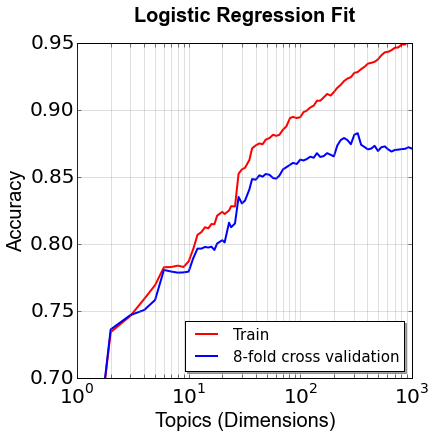

In [27]:
#things to plot
plt.plot(dimensions_used, scores_absolute, c="r", linestyle = '-', linewidth = 2, label = "Train")
plt.plot(dimensions_used, scores_cv, c="b", linestyle = '-', linewidth = 2, label = "8-fold cross validation")

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(1, 1000)
plt.xscale('log')
plt.ylim(0.70, 0.95)
plt.xlabel(r'Topics (Dimensions)', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Accuracy', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Logistic Regression Fit', y=1.05, fontdict = title_font)

#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 1, fontsize = 15, loc = 'lower right')
frame = legend.get_frame()
#frame.set_width(100)
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.savefig('data/cv_and_roc_data/cross_validation_adv_parse.png', bbox_inches='tight')

plt.show()

**Best cross validation score**

In [28]:
max_score = 0
for entry in zip(scores_cv, dimensions_used):
    if entry[0] > max_score:
        max_score = entry[0]
        max_d = entry[1]
print (max_score, max_d)

(0.88290420693422489, 327)


**Check out all the scores**

In [29]:
print zip(scores_cv, dimensions_used)

[(0.51947372824843518, 1), (0.73631522602367427, 2), (0.74701994455257792, 3), (0.75086591272035741, 4), (0.75833503776351097, 5), (0.78075023092551854, 6), (0.77953826933783033, 7), (0.77872920995729578, 8), (0.77893310281257755, 9), (0.77953989892908238, 10), (0.78963097516089731, 11), (0.79669459549961286, 12), (0.79669362680985822, 13), (0.79790753947995752, 14), (0.79750366225863289, 15), (0.79810947914468933, 16), (0.79568067035776457, 17), (0.80053177167474421, 18), (0.80295373111887691, 20), (0.80133789441800285, 21), (0.8160719280497305, 23), (0.8126484235085466, 24), (0.81547523729631377, 26), (0.83525741997378822, 28), (0.83040926267257009, 30), (0.83262994335346863, 32), (0.84090877181354406, 35), (0.84858015801258846, 37), (0.84817856812180525, 40), (0.85140697812477184, 43), (0.85039663260251741, 46), (0.85241471587939488, 49), (0.85180857328590187, 53), (0.84938530784981481, 57), (0.84898403839612124, 61), (0.85120504373038686, 65), (0.85584832999994442, 70), (0.85746579

**Conclusion**: Overall, 250 dimensions seems to be a good number as rapidly diminishing returns are found beyond this. The CV accuracy for this dimensionality is ~0.863, not so bad. This is the dimensionality employed for the rest of the notebook.

###7. Make and test a model with desired dimensionality

---

1. Create a k-fold receiver operating characteristic (ROC) curve (see: https://en.wikipedia.org/wiki/Receiver_operating_characteristic for more details).
  * This checks how well the model "separates" the two classes by plotting the "true positive rate" vs the "false positive rate" while moving the probability cutoff for classifying into one of the two categories (the default for classification is 50%).
2. Calculate various scores (train and test accuracies as well as the F1 score)
3. Generate a confusion matrix to see where the model goes wrong in classification

**Create the model and grab a few topics to look at later**

I have chosen the top 10 topics and the top 10 tokens of each

In [30]:
dimensions = 250
df_lsi_features, topics = latent_semantic_analysis(df_filtered, dictionary, corpus_tfidf, dimensions, True, 15, 10)

**Function to perform a k-fold ROC analysis and plot the results**

In [31]:
#so a dimensionality of ~100 seems perfectly fine... lets use this dimensionality and create a k-fold ROC curve
def k_fold_roc(df, dim, cross_val_num):
    #model used
    model = linear_model.LogisticRegression()
    
    #create X and y data but need as a numpy array for easy cv ROC implementation
    #also need to usue dummies for the ROC curve so convert them en route
    X = pd.DataFrame.as_matrix(df[[i for i in range(dim)]])
    y = pd.get_dummies(df["choose_one"])["Relevant"]
    
    #create the cross validation entity to extract the dat from sequentially
    cv = cross_validation.StratifiedKFold(y, n_folds = cross_val_num)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    roc_data = []
    for i, (train, test) in enumerate(cv):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        roc_data.append([fpr, tpr, ('%d (area = %0.2f)' % (i, roc_auc))])
    
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    roc_data.append([mean_fpr, mean_tpr, ('Mean (area = %0.2f)' % mean_auc)])
        
    return roc_data

**Generate the k-fold ROC curve and plot**

In [32]:
cross_val_num = 8
roc_data = k_fold_roc(df_lsi_features, dimensions, cross_val_num)

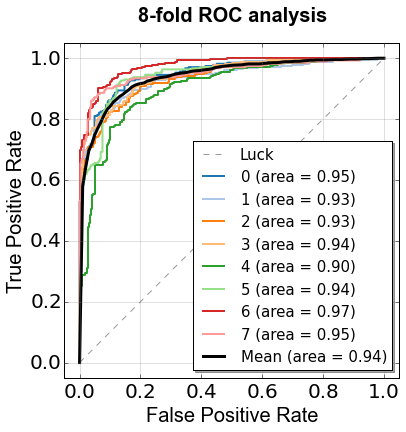

In [33]:
#color palette
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

i=0
for roc in roc_data[:-1]:
    plt.plot(roc[0], roc[1], lw=2, label=roc[2], color = tableau20[i])
    i = i + 1

roc = roc_data[-1]
plt.plot(roc[0], roc[1], 'k-', lw=3, label=roc[2])
    
#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
    
#axis and label details
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=20, fontdict = axis_label_font)
plt.ylabel('True Positive Rate', fontsize=20, fontdict = axis_label_font)
    
#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title(('%d-fold ROC analysis' % cross_val_num), y=1.05, fontdict = title_font)
    
#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 1
                        , fontsize = 15, loc = 'lower right', bbox_to_anchor=(1.0, 0.0))
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.savefig('data/cv_and_roc_data/roc_adv_parse.png', bbox_inches='tight')
    
plt.show()


The ROC analysis suggests the model does a good job at separating out the classes. 

**Fit a logistic regression model (one test-train split)**

  1. Calculate train accuracy
  2. Calculate test accuracy
  3. Calculate the F1 score
  4. Generate a confusion matrix

In [49]:
#make the X and y
X = df_lsi_features[[i for i in range(dimensions)]]
y = df_lsi_features["choose_one"]

#split into test and train
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.80)

#make the model
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#various "fitness" metrics
print "Train accuracy: %f \n" % model.score(X_train, y_train)
print "Test accuracy: %f \n" % model.score(X_test, y_test)
print "F1 score: %f \n" % metrics.f1_score(y_test, y_pred, labels=None, pos_label='Relevant', average='binary', sample_weight=None)

#confusion matrix
cm = metrics.confusion_matrix(y_test, model.predict(X_test))
print "Confusion matrix: \n"
print "-Legend"
print np.array([['True "not disaster"', 'False "disaster"'],['False "not disaster"', 'True "disaster"']])
print "\n-Prediction"
print cm

Train accuracy: 0.918223 

Test accuracy: 0.911201 

F1 score: 0.894988 

Confusion matrix: 

-Legend
[['True "not disaster"' 'False "disaster"']
 ['False "not disaster"' 'True "disaster"']]

-Prediction
[[528  29]
 [ 59 375]]


Overall, the three scores are very good for this model. It may be desirable to change the cutoff for classification to lean towards false disaster prediction--the consequences of missing a disaster far outweigh the cost of misclassifying some. This is a balance of course as you don’t want to say everything is a disaster. 

**Check out where the model is going wrong** 

For this I will create two new dataframes of incorrectly identified disasters or not

In [50]:
df_test = y_test
index_vals = df_test.index
df_pred = pd.DataFrame(y_pred, columns = ["predicted"]).set_index(keys = index_vals)

In [51]:
df_wrong = pd.concat([df_test, df_pred, df_filtered['text_tokenized_stemmed_w2v']], axis=1)

In [52]:
df_wrong = df_wrong.dropna()
df_wrong = df_wrong[df_wrong["choose_one"] != df_wrong["predicted"]]

In [53]:
df_wrong_false_disaster = df_wrong[df_wrong["predicted"] == "Relevant"]
df_wrong_false_non_disaster = df_wrong[df_wrong["predicted"] == "Not Relevant"]

In [54]:
print len(df_wrong_false_disaster)
print len(df_wrong_false_non_disaster)
df_wrong_false_non_disaster

29
59


,choose_one,predicted,text_tokenized_stemmed_w2v
10,Relevant,Not Relevant,"[we'r, shake, ..., it', an, earthquak]"
62,Relevant,Not Relevant,"[@, navista7, steve, these, fire, out, here, a..."
150,Relevant,Not Relevant,"[#, omg, !, i, don't, believ, thi, ., #, rip, ..."
194,Relevant,Not Relevant,"[annihil, in, syria, :, syrian, armi, grind, '..."
245,Relevant,Not Relevant,"[#, turkey, invad, #, israel, halfway, to, #, ..."
249,Relevant,Not Relevant,"[@, huffman, again, ?, ?, tch, !, thought, of,..."
272,Relevant,Not Relevant,"[victorinox, swiss, armi, date, women', rubber..."
289,Relevant,Not Relevant,"[thousand, attend, a, ralli, organ, by, peac, ..."
326,Relevant,Not Relevant,"[suspect, serial, arsonist, in, east, bay, und..."
436,Relevant,Not Relevant,"[@, |-no_w2v-|, that', good, to, hear, ., mine..."


In [55]:
df_filtered['text_tokenized_stemmed_w2v'][4947]

[u'#',
 u'?',
 u'?',
 u'?',
 u'#',
 u'?',
 u'?',
 u'#',
 u'?',
 u'?',
 u'?',
 u'#',
 u'?',
 u'?',
 u'?',
 u'|-num_alpha-|',
 u':',
 u'aircraft',
 u'debri',
 u'found',
 u'on',
 u'la',
 u'reunion',
 u'is',
 u'from',
 u'miss',
 u'malaysia',
 u'airlin',
 u'...',
 u'|-website-|']

###8. Check out the "topics"

---

  1. Print out the top 10 topics with the top ten tokens they are composed of
  2. Plot some topics against each other with colors to indicate class

**Print the topics**

In [56]:
for topic in topics:
    print "Topic %d:" % topic[0]
    print topic[1] + "\n"

Topic 0:
0.403*"?" + 0.237*"#" + 0.196*"'" + 0.185*"the" + 0.184*"." + 0.177*"a" + 0.170*"i" + 0.168*"@" + 0.167*"|-num-|" + 0.149*":"

Topic 1:
-0.826*"?" + 0.156*"'" + 0.147*"|-num-|" + 0.145*":" + 0.106*"#" + 0.105*"of" + 0.098*"famili" + 0.098*"in" + 0.092*"by" + 0.091*"|-website-|"

Topic 2:
-0.280*"'" + -0.228*"?" + -0.215*"famili" + 0.212*"a" + 0.210*"airport" + 0.210*"sandstorm" + 0.208*"swallow" + 0.205*"minut" + 0.195*"under" + 0.192*"watch"

Topic 3:
0.281*"by" + 0.239*"airport" + 0.238*"sandstorm" + 0.237*"swallow" + 0.224*"minut" + 0.221*"under" + 0.207*"raze" + 0.203*"wildfir" + 0.203*"northern" + 0.202*"latest"

Topic 4:
0.447*"'" + -0.254*"#" + 0.224*"famili" + -0.223*"california" + -0.219*"northern" + -0.210*"wildfir" + -0.202*"latest" + -0.201*"raze" + -0.197*"home" + 0.172*"legionnair"

Topic 5:
0.298*"suicid" + 0.266*"bomber" + 0.210*"bomb" + 0.201*"kill" + 0.191*"#" + 0.177*"mosqu" + 0.172*"saudi" + 0.172*"|-num-|" + 0.148*"?" + 0.146*"pkk"

Topic 6:
0.569*"#" + -0

The topics seem to progressively become more relevant to disasters based on the words. The lower order ones will likely serve as better for identifying non-disasters while later ones disasters. This can be confirmed by plotting the topics against one another.

**Plot topics**

Topic 1 seems better for identifying non-disasters while topic 9 is better for disasters. Let’s check...

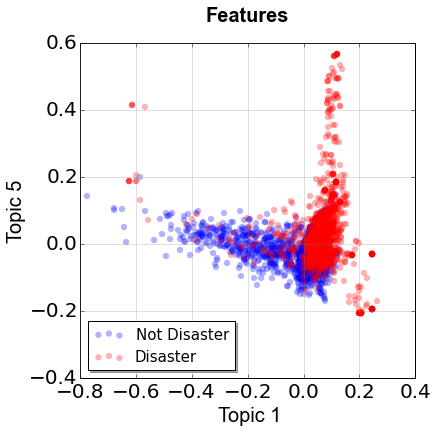

In [60]:
#set the two topics
feature_1 = 1
feature_2 = 5

#extract the data for plotting
feature_1_not_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Not Relevant"][feature_1]
feature_2_not_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Not Relevant"][feature_2]
feature_1_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Relevant"][feature_1]
feature_2_relevant = df_lsi_features[df_lsi_features["choose_one"] == "Relevant"][feature_2]

#things to plot
plt.scatter(feature_1_not_relevant, feature_2_not_relevant, c="b", s=40, alpha=0.3, linewidths=0.0, label = "Not Disaster")
plt.scatter(feature_1_relevant, feature_2_relevant, c="r", s=40, alpha=0.3, linewidths=0.0, label = "Disaster")


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#axis range and labels (also specify if log or not)
plt.xlim(-0.8, 0.4)
#plt.xscale('log')
plt.ylim(-0.4, 0.6)
plt.xlabel(r'Topic ' + str(feature_1), y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'Topic ' + str(feature_2), fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Features', y=1.05, fontdict = title_font)

#legend details
legend = plt.legend(shadow = True, frameon = True, fancybox = False, ncol = 1, fontsize = 15, loc = 'lower left')
frame = legend.get_frame()
#frame.set_width(100)
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.savefig('data/cv_and_roc_data/topics-adv_parse.png', bbox_inches='tight')
    
plt.show()

Indeed, the topics match our intuition based on what tokens they contain! Topic 1 pulls out many non-disaster tweets from the "clump" near the origin while topic 9 does the same (though more weakly so) for disaster tweets. With hundreds of topics to work with, good separation is possible.

#To be continued...

In [ ]:
from numpy import log

class Word_Splicer:

    def __init__(self):
        self.frequencies = {}
        self.split_sequence_locker = {}

    def make_freq(self, word_bank):
        word_bank_L = [word for word in word_bank]
        for token in word_bank_L:               
            if token in self.frequencies:
                self.frequencies[token] = self.frequencies[token] + 1.0
            elif token.isalpha():
                self.frequencies[token] = 1.0
                
    def log_freq(self, token):
        if token in self.frequencies:
            return log(self.frequencies[token])
        elif token.isalpha() and len(token) < 3:
            return -10.0
        else:
            return 0.0

    def gen_sequence(self, num_splits, splits, max_pos):
        if len(splits) == 0:
            min_split = 1
        else:
            min_split = splits[-1] + 1

        if len(splits) < num_splits:
            for new_split in range(min_split, max_pos + 1):
                splits_out = deepcopy(splits)
                splits_out.append(new_split)
                self.gen_sequence(num_splits, deepcopy(splits_out), max_pos)
        else:
            self.split_sequence_locker[(num_splits, max_pos)].append(splits)
            
    def break_tokens(self, conjoined_tokens, split_sequence):
        broken_tokens = []
        
        split_h = split_sequence[0]
        broken_tokens.append(conjoined_tokens[:split_h])
        for i in range(0, len(split_sequence) - 1):
            split_l = split_sequence[i]
            split_h = split_sequence[i + 1]
            broken_tokens.append(conjoined_tokens[split_l:split_h])   
        split_l = split_sequence[-1]
        broken_tokens.append(conjoined_tokens[split_l:])
        
        return broken_tokens
        
    def max_prob_split(self, conjoined_tokens, degree):
        
        max_pos = len(conjoined_tokens) - 1
        
        #max_proba = -1.0*(10.0**20.0)
        max_proba = self.log_freq(conjoined_tokens)
        max_broken_tokens = deepcopy(conjoined_tokens)
        
        #for num_splits in range(1, max_pos + 1):
        for num_splits in range(1, degree + 1):
            if (num_splits, max_pos) not in self.split_sequence_locker:
                self.split_sequence_locker[(num_splits, max_pos)] = []
                self.gen_sequence(num_splits, [], max_pos)
                
            for split_sequence in self.split_sequence_locker[(num_splits, max_pos)]:
                broken_tokens = self.break_tokens(conjoined_tokens, split_sequence)
                proba = sum([self.log_freq(token) for token in broken_tokens])
                if (proba > max_proba):
                    max_proba = proba
                    max_broken_tokens = broken_tokens
        
        return max_broken_tokens